# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [ ]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [1]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [2]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [3]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [4]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,5.287134,8.690246,8.728203,8.632311,576145,ABEV3.SA,0
1,2011-01-03,6.304975,15.700000,15.900000,15.750000,6626800,BBAS3.SA,0
2,2011-01-03,6.361643,11.774127,11.927362,11.809763,10862336,BBDC4.SA,0
3,2011-01-03,10.177240,18.067982,18.250118,18.031555,10014663,ITUB4.SA,0
4,2011-01-03,6.115665,8.510648,8.629907,8.422694,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,16.668446,24.500000,25.049999,24.990000,57901800,PETR4.SA,3
29776,2022-12-29,37.150330,37.209999,37.480000,37.250000,7890300,PRIO3.SA,3
29777,2022-12-29,50.361668,53.025078,55.776001,54.300869,8786791,RENT3.SA,3
29778,2022-12-29,77.194099,88.879997,89.949997,89.000000,40110800,VALE3.SA,3


In [5]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2978,2978,2978,2978,2978,2978,2978
BBAS3.SA,2978,2978,2978,2978,2978,2978,2978
BBDC4.SA,2978,2978,2978,2978,2978,2978,2978
ITUB4.SA,2978,2978,2978,2978,2978,2978,2978
LREN3.SA,2978,2978,2978,2978,2978,2978,2978
PETR4.SA,2978,2978,2978,2978,2978,2978,2978
PRIO3.SA,2978,2978,2978,2978,2978,2978,2978
RENT3.SA,2978,2978,2978,2978,2978,2978,2978
VALE3.SA,2978,2978,2978,2978,2978,2978,2978


### Normalize Data

We normalize the data dividing the time series of each stock by its maximum value, so that the dataframe contains values between 0 and 1.

In [6]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00200262 0.00114137 0.0010422  ... 0.04565734 0.05214546 0.07760399]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, sel

,date,open,high,low,close,volume,tic,day
0,2011-01-03,0.273169,0.358065,0.355383,0.353928,0.002003,ABEV3.SA,0.00
1,2011-01-03,0.320289,0.569047,0.568771,0.566547,0.014581,BBAS3.SA,0.00
2,2011-01-03,0.284472,0.397649,0.397479,0.396939,0.021760,BBDC4.SA,0.00
3,2011-01-03,0.328329,0.455228,0.458661,0.466293,0.062331,ITUB4.SA,0.00
4,2011-01-03,0.126038,0.155025,0.157120,0.153498,0.072591,LREN3.SA,0.00
...,...,...,...,...,...,...,...,...
29775,2022-12-29,0.694899,0.649523,0.652514,0.663745,0.082841,PETR4.SA,0.75
29776,2022-12-29,0.857373,0.857373,0.844144,0.858295,0.048724,PRIO3.SA,0.75
29777,2022-12-29,0.728877,0.720611,0.754746,0.737949,0.097191,RENT3.SA,0.75
29778,2022-12-29,0.916710,0.748652,0.746783,0.742905,0.218546,VALE3.SA,0.75


In [7]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [8]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [9]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [10]:
episodes = 100

In [11]:
DRLAgent.train_model(model, episodes=episodes)

  0%|          | 0/100 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 289836.03125
Final accumulative portfolio value: 2.8983603125
Maximum DrawDown: -0.4599906867578206
Sharpe ratio: 0.6499955797525391


  1%|          | 1/100 [00:10<17:42, 10.74s/it]

Initial portfolio value:100000
Final portfolio value: 495354.15625
Final accumulative portfolio value: 4.9535415625
Maximum DrawDown: -0.4954635237800624
Sharpe ratio: 0.8881347525464215


  2%|▏         | 2/100 [00:21<17:22, 10.63s/it]

Initial portfolio value:100000
Final portfolio value: 746462.4375
Final accumulative portfolio value: 7.464624375
Maximum DrawDown: -0.5937176731860812
Sharpe ratio: 0.9418089406549494


  3%|▎         | 3/100 [00:32<17:17, 10.69s/it]

Initial portfolio value:100000
Final portfolio value: 861949.5
Final accumulative portfolio value: 8.619495
Maximum DrawDown: -0.6635008618563316
Sharpe ratio: 0.8997681226366392


  4%|▍         | 4/100 [00:42<17:03, 10.67s/it]

Initial portfolio value:100000
Final portfolio value: 1102239.875
Final accumulative portfolio value: 11.02239875
Maximum DrawDown: -0.7049256322393747
Sharpe ratio: 0.89696496970024


  5%|▌         | 5/100 [00:53<16:53, 10.67s/it]

Initial portfolio value:100000
Final portfolio value: 1063058.125
Final accumulative portfolio value: 10.63058125
Maximum DrawDown: -0.6867059411750456
Sharpe ratio: 0.9050083345025652


  6%|▌         | 6/100 [01:04<16:42, 10.67s/it]

Initial portfolio value:100000
Final portfolio value: 1231518.125
Final accumulative portfolio value: 12.31518125
Maximum DrawDown: -0.7244922933180501
Sharpe ratio: 0.8953948305155301


  7%|▋         | 7/100 [01:14<16:28, 10.63s/it]

Initial portfolio value:100000
Final portfolio value: 1256393.5
Final accumulative portfolio value: 12.563935
Maximum DrawDown: -0.7100551673629167
Sharpe ratio: 0.910802866891036


  8%|▊         | 8/100 [01:25<16:16, 10.61s/it]

Initial portfolio value:100000
Final portfolio value: 1298328.5
Final accumulative portfolio value: 12.983285
Maximum DrawDown: -0.709400220605664
Sharpe ratio: 0.9140627592494511


  9%|▉         | 9/100 [01:35<16:07, 10.63s/it]

Initial portfolio value:100000
Final portfolio value: 1333315.625
Final accumulative portfolio value: 13.33315625
Maximum DrawDown: -0.7019205571511016
Sharpe ratio: 0.9219591818723266


 10%|█         | 10/100 [01:46<15:57, 10.64s/it]

Initial portfolio value:100000
Final portfolio value: 1360185.125
Final accumulative portfolio value: 13.60185125
Maximum DrawDown: -0.6926808515513876
Sharpe ratio: 0.9276732536182655


 11%|█         | 11/100 [01:57<15:46, 10.64s/it]

Initial portfolio value:100000
Final portfolio value: 1413660.875
Final accumulative portfolio value: 14.13660875
Maximum DrawDown: -0.6803050188371393
Sharpe ratio: 0.9402262021305469


 12%|█▏        | 12/100 [02:07<15:26, 10.53s/it]

Initial portfolio value:100000
Final portfolio value: 1473716.5
Final accumulative portfolio value: 14.737165
Maximum DrawDown: -0.6572583908426278
Sharpe ratio: 0.9603296694451277


 13%|█▎        | 13/100 [02:17<15:07, 10.44s/it]

Initial portfolio value:100000
Final portfolio value: 1549604.125
Final accumulative portfolio value: 15.49604125
Maximum DrawDown: -0.6415433401570008
Sharpe ratio: 0.9737320228742954


 14%|█▍        | 14/100 [02:27<14:51, 10.37s/it]

Initial portfolio value:100000
Final portfolio value: 1618071.25
Final accumulative portfolio value: 16.1807125
Maximum DrawDown: -0.6283827680548921
Sharpe ratio: 0.9851366247619224


 15%|█▌        | 15/100 [02:38<14:37, 10.33s/it]

Initial portfolio value:100000
Final portfolio value: 1739060.375
Final accumulative portfolio value: 17.39060375
Maximum DrawDown: -0.5899170732715115
Sharpe ratio: 1.0232758285812331


 16%|█▌        | 16/100 [02:48<14:33, 10.39s/it]

Initial portfolio value:100000
Final portfolio value: 1804371.125
Final accumulative portfolio value: 18.04371125
Maximum DrawDown: -0.6002636240853054
Sharpe ratio: 1.0240815681705764


 17%|█▋        | 17/100 [02:58<14:22, 10.39s/it]

Initial portfolio value:100000
Final portfolio value: 1933449.625
Final accumulative portfolio value: 19.33449625
Maximum DrawDown: -0.594419372862425
Sharpe ratio: 1.0341773173195372


 18%|█▊        | 18/100 [03:09<14:13, 10.41s/it]

Initial portfolio value:100000
Final portfolio value: 2165114.75
Final accumulative portfolio value: 21.6511475
Maximum DrawDown: -0.5234417054459508
Sharpe ratio: 1.0978777989308839


 19%|█▉        | 19/100 [03:19<13:59, 10.36s/it]

Initial portfolio value:100000
Final portfolio value: 2255224.5
Final accumulative portfolio value: 22.552245
Maximum DrawDown: -0.48540232720533616
Sharpe ratio: 1.1292209120601013


 20%|██        | 20/100 [03:29<13:46, 10.34s/it]

Initial portfolio value:100000
Final portfolio value: 2133089.25
Final accumulative portfolio value: 21.3308925
Maximum DrawDown: -0.6114401244534086
Sharpe ratio: 1.0328943014812544


 21%|██        | 21/100 [03:40<13:32, 10.29s/it]

Initial portfolio value:100000
Final portfolio value: 3142395.5
Final accumulative portfolio value: 31.423955
Maximum DrawDown: -0.5017207421046745
Sharpe ratio: 1.1937550889057165


 22%|██▏       | 22/100 [03:50<13:20, 10.27s/it]

Initial portfolio value:100000
Final portfolio value: 3753174.0
Final accumulative portfolio value: 37.53174
Maximum DrawDown: -0.5017452798657951
Sharpe ratio: 1.2745973144515539


 23%|██▎       | 23/100 [04:00<13:09, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 3624069.0
Final accumulative portfolio value: 36.24069
Maximum DrawDown: -0.5006954009256845
Sharpe ratio: 1.2717061777950212


 24%|██▍       | 24/100 [04:10<12:58, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 3617634.25
Final accumulative portfolio value: 36.1763425
Maximum DrawDown: -0.5026378070257866
Sharpe ratio: 1.2459044040831349


 25%|██▌       | 25/100 [04:21<12:47, 10.24s/it]

Initial portfolio value:100000
Final portfolio value: 4433953.5
Final accumulative portfolio value: 44.339535
Maximum DrawDown: -0.5086206991650306
Sharpe ratio: 1.2922350423772555


 26%|██▌       | 26/100 [04:31<12:39, 10.27s/it]

Initial portfolio value:100000
Final portfolio value: 4170457.5
Final accumulative portfolio value: 41.704575
Maximum DrawDown: -0.5037725153719643
Sharpe ratio: 1.2905525994976503


 27%|██▋       | 27/100 [04:41<12:28, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 2076708.5
Final accumulative portfolio value: 20.767085
Maximum DrawDown: -0.43919697389648615
Sharpe ratio: 1.1390964715646528


 28%|██▊       | 28/100 [04:51<12:16, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 1879657.75
Final accumulative portfolio value: 18.7965775
Maximum DrawDown: -0.5934069817197809
Sharpe ratio: 0.9859708213632932


 29%|██▉       | 29/100 [05:01<12:05, 10.22s/it]

Initial portfolio value:100000
Final portfolio value: 2330833.5
Final accumulative portfolio value: 23.308335
Maximum DrawDown: -0.6160288775977893
Sharpe ratio: 1.0143564822934215


 30%|███       | 30/100 [05:12<11:55, 10.22s/it]

Initial portfolio value:100000
Final portfolio value: 3286868.75
Final accumulative portfolio value: 32.8686875
Maximum DrawDown: -0.5099393075626102
Sharpe ratio: 1.1505590311515992


 31%|███       | 31/100 [05:22<11:45, 10.22s/it]

Initial portfolio value:100000
Final portfolio value: 4888323.5
Final accumulative portfolio value: 48.883235
Maximum DrawDown: -0.5106167724630635
Sharpe ratio: 1.272440154304062


 32%|███▏      | 32/100 [05:32<11:34, 10.22s/it]

Initial portfolio value:100000
Final portfolio value: 4500210.0
Final accumulative portfolio value: 45.0021
Maximum DrawDown: -0.5038421142113874
Sharpe ratio: 1.258812169903965


 33%|███▎      | 33/100 [05:42<11:24, 10.22s/it]

Initial portfolio value:100000
Final portfolio value: 921716.0
Final accumulative portfolio value: 9.21716
Maximum DrawDown: -0.8077702795222494
Sharpe ratio: 0.7349947885804826


 34%|███▍      | 34/100 [05:53<11:14, 10.22s/it]

Initial portfolio value:100000
Final portfolio value: 2418426.75
Final accumulative portfolio value: 24.1842675
Maximum DrawDown: -0.4234236750551208
Sharpe ratio: 1.1007803271266237


 35%|███▌      | 35/100 [06:03<11:05, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 852767.0625
Final accumulative portfolio value: 8.527670625
Maximum DrawDown: -0.5139923899111658
Sharpe ratio: 0.8601177425433769


 36%|███▌      | 36/100 [06:13<10:54, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 3241300.0
Final accumulative portfolio value: 32.413
Maximum DrawDown: -0.5083771018412213
Sharpe ratio: 1.150069492489499


 37%|███▋      | 37/100 [06:23<10:45, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 3116601.25
Final accumulative portfolio value: 31.1660125
Maximum DrawDown: -0.5044080787234608
Sharpe ratio: 1.1239912711137836


 38%|███▊      | 38/100 [06:34<10:37, 10.29s/it]

Initial portfolio value:100000
Final portfolio value: 3353230.75
Final accumulative portfolio value: 33.5323075
Maximum DrawDown: -0.5192190711206818
Sharpe ratio: 1.1313496302805046


 39%|███▉      | 39/100 [06:44<10:26, 10.28s/it]

Initial portfolio value:100000
Final portfolio value: 5152701.0
Final accumulative portfolio value: 51.52701
Maximum DrawDown: -0.511293663108873
Sharpe ratio: 1.2737150194025126


 40%|████      | 40/100 [06:54<10:15, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 6345311.0
Final accumulative portfolio value: 63.45311
Maximum DrawDown: -0.5110022778310416
Sharpe ratio: 1.3301685737578828


 41%|████      | 41/100 [07:04<10:04, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 2817607.75
Final accumulative portfolio value: 28.1760775
Maximum DrawDown: -0.40470606441874835
Sharpe ratio: 1.1825073196507403


 42%|████▏     | 42/100 [07:15<09:54, 10.24s/it]

Initial portfolio value:100000
Final portfolio value: 6033159.5
Final accumulative portfolio value: 60.331595
Maximum DrawDown: -0.5087997910757843
Sharpe ratio: 1.3302093508695545


 43%|████▎     | 43/100 [07:25<09:43, 10.24s/it]

Initial portfolio value:100000
Final portfolio value: 7235968.0
Final accumulative portfolio value: 72.35968
Maximum DrawDown: -0.5081283356240118
Sharpe ratio: 1.3574357584151906


 44%|████▍     | 44/100 [07:35<09:33, 10.24s/it]

Initial portfolio value:100000
Final portfolio value: 5847390.0
Final accumulative portfolio value: 58.4739
Maximum DrawDown: -0.5064088726924845
Sharpe ratio: 1.2793029189961922


 45%|████▌     | 45/100 [07:45<09:22, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 1274030.5
Final accumulative portfolio value: 12.740305
Maximum DrawDown: -0.7977807897799527
Sharpe ratio: 0.8094652791246822


 46%|████▌     | 46/100 [07:56<09:12, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 5832197.0
Final accumulative portfolio value: 58.32197
Maximum DrawDown: -0.5106864544371674
Sharpe ratio: 1.2753286837652527


 47%|████▋     | 47/100 [08:06<09:02, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 6521445.5
Final accumulative portfolio value: 65.214455
Maximum DrawDown: -0.5076793161312887
Sharpe ratio: 1.296341278890175


 48%|████▊     | 48/100 [08:16<08:51, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 4248262.0
Final accumulative portfolio value: 42.48262
Maximum DrawDown: -0.48204104568597694
Sharpe ratio: 1.2282997925763464


 49%|████▉     | 49/100 [08:26<08:41, 10.23s/it]

Initial portfolio value:100000
Final portfolio value: 2243932.0
Final accumulative portfolio value: 22.43932
Maximum DrawDown: -0.4740336568198398
Sharpe ratio: 1.078160233035025


 50%|█████     | 50/100 [08:36<08:30, 10.22s/it]

Initial portfolio value:100000
Final portfolio value: 4487073.5
Final accumulative portfolio value: 44.870735
Maximum DrawDown: -0.5111607520314516
Sharpe ratio: 1.1931264201682694


 51%|█████     | 51/100 [08:47<08:20, 10.21s/it]

Initial portfolio value:100000
Final portfolio value: 6579533.5
Final accumulative portfolio value: 65.795335
Maximum DrawDown: -0.5072891640109862
Sharpe ratio: 1.3010692127038959


 52%|█████▏    | 52/100 [08:57<08:13, 10.28s/it]

Initial portfolio value:100000
Final portfolio value: 9149824.0
Final accumulative portfolio value: 91.49824
Maximum DrawDown: -0.5106388367501361
Sharpe ratio: 1.3717426158917236


 53%|█████▎    | 53/100 [09:07<08:02, 10.27s/it]

Initial portfolio value:100000
Final portfolio value: 7813280.0
Final accumulative portfolio value: 78.1328
Maximum DrawDown: -0.5115494355394927
Sharpe ratio: 1.3154248746769532


 54%|█████▍    | 54/100 [09:17<07:51, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 8194116.5
Final accumulative portfolio value: 81.941165
Maximum DrawDown: -0.5095651433777264
Sharpe ratio: 1.3358985751490093


 55%|█████▌    | 55/100 [09:28<07:40, 10.24s/it]

Initial portfolio value:100000
Final portfolio value: 8881031.0
Final accumulative portfolio value: 88.81031
Maximum DrawDown: -0.5100218355643626
Sharpe ratio: 1.3668138808648116


 56%|█████▌    | 56/100 [09:39<07:41, 10.49s/it]

Initial portfolio value:100000
Final portfolio value: 9343926.0
Final accumulative portfolio value: 93.43926
Maximum DrawDown: -0.5107106866019182
Sharpe ratio: 1.3725039271623514


 57%|█████▋    | 57/100 [09:49<07:28, 10.44s/it]

Initial portfolio value:100000
Final portfolio value: 9344667.0
Final accumulative portfolio value: 93.44667
Maximum DrawDown: -0.5118208006617657
Sharpe ratio: 1.3492849972908052


 58%|█████▊    | 58/100 [09:59<07:16, 10.39s/it]

Initial portfolio value:100000
Final portfolio value: 3481675.25
Final accumulative portfolio value: 34.8167525
Maximum DrawDown: -0.4512280559539219
Sharpe ratio: 1.1683965864244095


 59%|█████▉    | 59/100 [10:10<07:04, 10.35s/it]

Initial portfolio value:100000
Final portfolio value: 8847598.0
Final accumulative portfolio value: 88.47598
Maximum DrawDown: -0.5089404480847988
Sharpe ratio: 1.3733312772564283


 60%|██████    | 60/100 [10:20<06:52, 10.31s/it]

Initial portfolio value:100000
Final portfolio value: 8162783.5
Final accumulative portfolio value: 81.627835
Maximum DrawDown: -0.506196797341947
Sharpe ratio: 1.3441981831752803


 61%|██████    | 61/100 [10:30<06:41, 10.29s/it]

Initial portfolio value:100000
Final portfolio value: 11242919.0
Final accumulative portfolio value: 112.42919
Maximum DrawDown: -0.5117068660772539
Sharpe ratio: 1.394076437551972


 62%|██████▏   | 62/100 [10:40<06:30, 10.28s/it]

Initial portfolio value:100000
Final portfolio value: 8927592.0
Final accumulative portfolio value: 89.27592
Maximum DrawDown: -0.5113436701375962
Sharpe ratio: 1.3504877675612423


 63%|██████▎   | 63/100 [10:51<06:21, 10.31s/it]

Initial portfolio value:100000
Final portfolio value: 11350131.0
Final accumulative portfolio value: 113.50131
Maximum DrawDown: -0.5119099302907428
Sharpe ratio: 1.4011794185465498


 64%|██████▍   | 64/100 [11:01<06:10, 10.29s/it]

Initial portfolio value:100000
Final portfolio value: 7437594.0
Final accumulative portfolio value: 74.37594
Maximum DrawDown: -0.5119871281887227
Sharpe ratio: 1.2970907774758442


 65%|██████▌   | 65/100 [11:11<05:59, 10.27s/it]

Initial portfolio value:100000
Final portfolio value: 6514498.5
Final accumulative portfolio value: 65.144985
Maximum DrawDown: -0.5110132784939635
Sharpe ratio: 1.310976100746353


 66%|██████▌   | 66/100 [11:21<05:48, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 4210223.0
Final accumulative portfolio value: 42.10223
Maximum DrawDown: -0.5063625299603487
Sharpe ratio: 1.176328818071984


 67%|██████▋   | 67/100 [11:32<05:38, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 7561461.5
Final accumulative portfolio value: 75.614615
Maximum DrawDown: -0.5118570848307942
Sharpe ratio: 1.2980764353893788


 68%|██████▊   | 68/100 [11:42<05:28, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 5472479.5
Final accumulative portfolio value: 54.724795
Maximum DrawDown: -0.4910834690220647
Sharpe ratio: 1.2368061226354148


 69%|██████▉   | 69/100 [11:52<05:17, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 1970689.375
Final accumulative portfolio value: 19.70689375
Maximum DrawDown: -0.7107867119336212
Sharpe ratio: 0.9210199402582322


 70%|███████   | 70/100 [12:03<05:12, 10.41s/it]

Initial portfolio value:100000
Final portfolio value: 5535849.0
Final accumulative portfolio value: 55.35849
Maximum DrawDown: -0.5119685353913854
Sharpe ratio: 1.231067954792259


 71%|███████   | 71/100 [12:14<05:05, 10.52s/it]

Initial portfolio value:100000
Final portfolio value: 4431356.0
Final accumulative portfolio value: 44.31356
Maximum DrawDown: -0.5488382701004637
Sharpe ratio: 1.1313192755938952


 72%|███████▏  | 72/100 [12:24<04:52, 10.45s/it]

Initial portfolio value:100000
Final portfolio value: 6392400.5
Final accumulative portfolio value: 63.924005
Maximum DrawDown: -0.5060515870921989
Sharpe ratio: 1.262964080618495


 73%|███████▎  | 73/100 [12:34<04:40, 10.39s/it]

Initial portfolio value:100000
Final portfolio value: 3485253.0
Final accumulative portfolio value: 34.85253
Maximum DrawDown: -0.7627936264934245
Sharpe ratio: 0.9868054489192802


 74%|███████▍  | 74/100 [12:45<04:29, 10.35s/it]

Initial portfolio value:100000
Final portfolio value: 928380.0
Final accumulative portfolio value: 9.2838
Maximum DrawDown: -0.8490132354928954
Sharpe ratio: 0.7218481553985696


 75%|███████▌  | 75/100 [12:55<04:18, 10.32s/it]

Initial portfolio value:100000
Final portfolio value: 5878424.5
Final accumulative portfolio value: 58.784245
Maximum DrawDown: -0.5092541996015958
Sharpe ratio: 1.2576530883699208


 76%|███████▌  | 76/100 [13:05<04:07, 10.30s/it]

Initial portfolio value:100000
Final portfolio value: 4979882.0
Final accumulative portfolio value: 49.79882
Maximum DrawDown: -0.5111659795959466
Sharpe ratio: 1.2093967284361855


 77%|███████▋  | 77/100 [13:15<03:56, 10.28s/it]

Initial portfolio value:100000
Final portfolio value: 6913146.5
Final accumulative portfolio value: 69.131465
Maximum DrawDown: -0.5047482517012268
Sharpe ratio: 1.2959945531647052


 78%|███████▊  | 78/100 [13:26<03:46, 10.28s/it]

Initial portfolio value:100000
Final portfolio value: 5754350.5
Final accumulative portfolio value: 57.543505
Maximum DrawDown: -0.5223324251390764
Sharpe ratio: 1.2212664916224794


 79%|███████▉  | 79/100 [13:36<03:35, 10.27s/it]

Initial portfolio value:100000
Final portfolio value: 10939071.0
Final accumulative portfolio value: 109.39071
Maximum DrawDown: -0.5117975378288713
Sharpe ratio: 1.4028134347647376


 80%|████████  | 80/100 [13:46<03:25, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 12946630.0
Final accumulative portfolio value: 129.4663
Maximum DrawDown: -0.5117785323300408
Sharpe ratio: 1.446904417645501


 81%|████████  | 81/100 [13:56<03:14, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 13255027.0
Final accumulative portfolio value: 132.55027
Maximum DrawDown: -0.5119776427096587
Sharpe ratio: 1.4387944329904019


 82%|████████▏ | 82/100 [14:06<03:04, 10.24s/it]

Initial portfolio value:100000
Final portfolio value: 3662654.75
Final accumulative portfolio value: 36.6265475
Maximum DrawDown: -0.44796121024564794
Sharpe ratio: 1.1638378940918979


 83%|████████▎ | 83/100 [14:17<02:54, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 12147159.0
Final accumulative portfolio value: 121.47159
Maximum DrawDown: -0.5116052960792911
Sharpe ratio: 1.4424773824925303


 84%|████████▍ | 84/100 [14:27<02:44, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 13951169.0
Final accumulative portfolio value: 139.51169
Maximum DrawDown: -0.5119025553397146
Sharpe ratio: 1.461447631544817


 85%|████████▌ | 85/100 [14:37<02:33, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 13911146.0
Final accumulative portfolio value: 139.11146
Maximum DrawDown: -0.511983774510703
Sharpe ratio: 1.4352371869708602


 86%|████████▌ | 86/100 [14:48<02:23, 10.25s/it]

Initial portfolio value:100000
Final portfolio value: 5293196.0
Final accumulative portfolio value: 52.93196
Maximum DrawDown: -0.4447909066141239
Sharpe ratio: 1.2494871204436664


 87%|████████▋ | 87/100 [14:58<02:13, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 7812297.0
Final accumulative portfolio value: 78.12297
Maximum DrawDown: -0.568702108970212
Sharpe ratio: 1.2466859468376015


 88%|████████▊ | 88/100 [15:08<02:03, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 1412275.375
Final accumulative portfolio value: 14.12275375
Maximum DrawDown: -0.5409178116567777
Sharpe ratio: 0.9077959369676153


 89%|████████▉ | 89/100 [15:18<01:52, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 356659.5
Final accumulative portfolio value: 3.566595
Maximum DrawDown: -0.8134372147733144
Sharpe ratio: 0.5511027722554263


 90%|█████████ | 90/100 [15:29<01:42, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 7783098.5
Final accumulative portfolio value: 77.830985
Maximum DrawDown: -0.6214961310719934
Sharpe ratio: 1.223223180299138


 91%|█████████ | 91/100 [15:39<01:32, 10.26s/it]

Initial portfolio value:100000
Final portfolio value: 2567287.5
Final accumulative portfolio value: 25.672875
Maximum DrawDown: -0.714938082978055
Sharpe ratio: 0.9453035672813888


 92%|█████████▏| 92/100 [15:49<01:22, 10.35s/it]

Initial portfolio value:100000
Final portfolio value: 7484918.5
Final accumulative portfolio value: 74.849185
Maximum DrawDown: -0.5118716251299403
Sharpe ratio: 1.3289794635889904


 93%|█████████▎| 93/100 [16:00<01:12, 10.33s/it]

Initial portfolio value:100000
Final portfolio value: 6933438.0
Final accumulative portfolio value: 69.33438
Maximum DrawDown: -0.5119102747287916
Sharpe ratio: 1.2891314111371037


 94%|█████████▍| 94/100 [16:10<01:01, 10.31s/it]

Initial portfolio value:100000
Final portfolio value: 8647800.0
Final accumulative portfolio value: 86.478
Maximum DrawDown: -0.5119887863715957
Sharpe ratio: 1.3343318217050346


 95%|█████████▌| 95/100 [16:22<00:53, 10.69s/it]

Initial portfolio value:100000
Final portfolio value: 14788228.0
Final accumulative portfolio value: 147.88228
Maximum DrawDown: -0.5119670646497658
Sharpe ratio: 1.4574517753298228


 96%|█████████▌| 96/100 [16:32<00:42, 10.59s/it]

Initial portfolio value:100000
Final portfolio value: 13438203.0
Final accumulative portfolio value: 134.38203
Maximum DrawDown: -0.5117118932891191
Sharpe ratio: 1.416557698564733


 97%|█████████▋| 97/100 [16:43<00:31, 10.62s/it]

Initial portfolio value:100000
Final portfolio value: 8650262.0
Final accumulative portfolio value: 86.50262
Maximum DrawDown: -0.5022698669726755
Sharpe ratio: 1.2936038402150978


 98%|█████████▊| 98/100 [16:53<00:21, 10.54s/it]

Initial portfolio value:100000
Final portfolio value: 804800.6875
Final accumulative portfolio value: 8.048006875
Maximum DrawDown: -0.9335760435926311
Sharpe ratio: 0.6478941687049349


 99%|█████████▉| 99/100 [17:03<00:10, 10.49s/it]

Initial portfolio value:100000
Final portfolio value: 1424595.625
Final accumulative portfolio value: 14.24595625
Maximum DrawDown: -0.8189950417966887
Sharpe ratio: 0.8151379391859778


100%|██████████| 100/100 [17:14<00:00, 10.34s/it]


### 至多允许100个episode之后就没有什么变化了

### Save Model

In [12]:
model_name = f"policy_EIIE_episodes{episodes}.pt"
torch.save(model.train_policy.state_dict(), model_name)

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [13]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

### Test EIIE architecture

Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [14]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load(model_name))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_46538/2957330399.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(model_name

Initial portfolio value:100000
Final portfolio value: 171978.53125
Final accumulative portfolio value: 1.7197853125
Maximum DrawDown: -0.4780347265625
Sharpe ratio: 1.1690057093693893
Initial portfolio value:100000
Final portfolio value: 99999.9921875
Final accumulative portfolio value: 0.999999921875
Maximum DrawDown: -1.5625000004959588e-07
Sharpe ratio: 0.0
Initial portfolio value:100000
Final portfolio value: 99999.9765625
Final accumulative portfolio value: 0.999999765625
Maximum DrawDown: -7.812495727010926e-07
Sharpe ratio: -0.2641118743184138


In [28]:
EIIE_results["2021"]["value"]

[100000,
 102859.625,
 101975.375,
 102306.0,
 101329.88,
 100625.664,
 98848.84,
 101217.88,
 101996.016,
 102298.05,
 104819.875,
 104568.24,
 104012.65,
 104689.79,
 104198.55,
 104556.28,
 103314.805,
 104027.56,
 104411.54,
 105413.64,
 106201.91,
 105768.11,
 107277.23,
 106368.16,
 105919.48,
 104240.68,
 105062.56,
 104525.37,
 104381.7,
 105583.55,
 103588.05,
 104362.53,
 104084.93,
 103565.984,
 104783.23,
 105592.21,
 106984.71,
 105547.11,
 106319.87,
 104756.39,
 106874.99,
 107051.02,
 108668.03,
 107975.195,
 108535.8,
 108982.414,
 109109.41,
 110753.625,
 109947.125,
 110753.305,
 111276.53,
 112799.586,
 114289.69,
 115134.195,
 117093.25,
 118226.4,
 118358.875,
 118190.414,
 118245.72,
 117677.34,
 117785.84,
 118151.31,
 118213.984,
 117550.79,
 115061.46,
 115333.88,
 115739.664,
 115190.57,
 115453.664,
 115172.67,
 112812.59,
 112440.414,
 112106.17,
 112331.016,
 112499.836,
 113235.016,
 112882.875,
 112522.52,
 110878.24,
 112307.984,
 112433.61,
 114516.46,

### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [15]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 305207.125
Final accumulative portfolio value: 3.05207125
Maximum DrawDown: -0.5053701509312757
Sharpe ratio: 0.6258359181016153
Initial portfolio value:100000
Final portfolio value: 165052.671875
Final accumulative portfolio value: 1.65052671875
Maximum DrawDown: -0.28665109375
Sharpe ratio: 1.5639604621704621
Initial portfolio value:100000
Final portfolio value: 94232.390625
Final accumulative portfolio value: 0.94232390625
Maximum DrawDown: -0.20386432934124032
Sharpe ratio: -0.31032646699394256
Initial portfolio value:100000
Final portfolio value: 107326.2578125
Final accumulative portfolio value: 1.073262578125
Maximum DrawDown: -0.1837321269587393
Sharpe ratio: 0.48346772521463005


### Plot graphics

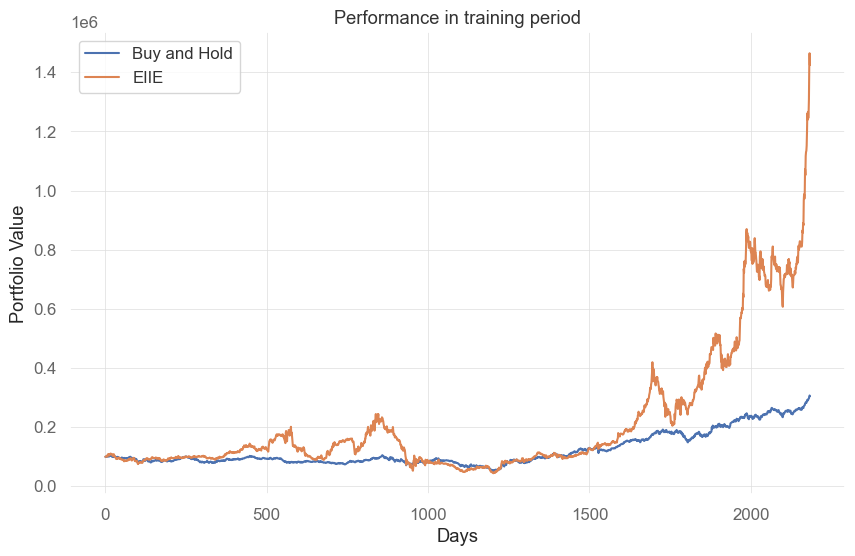

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()
plt.savefig(f"results/performance_in_training_episode{episodes}.png")
plt.show()

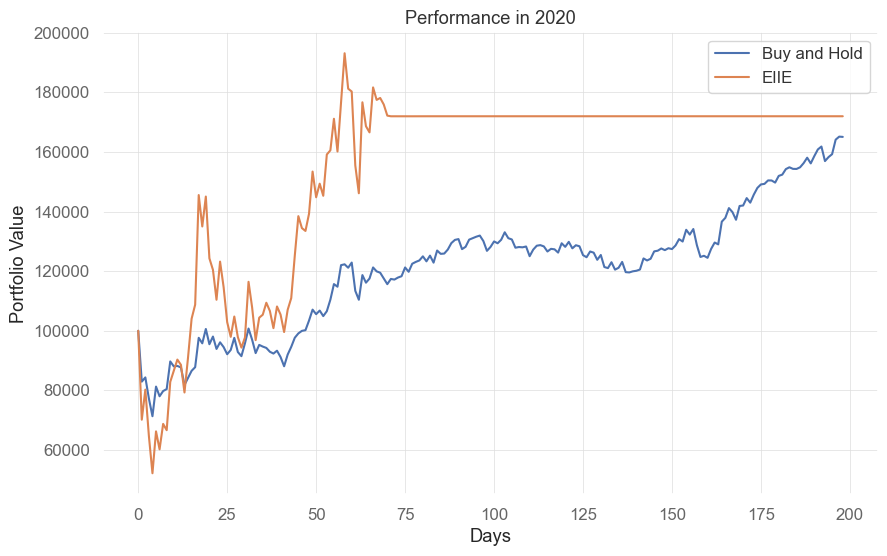

In [17]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()
plt.savefig(f"results/performance_in_2020_episode{episodes}.png")
plt.show()

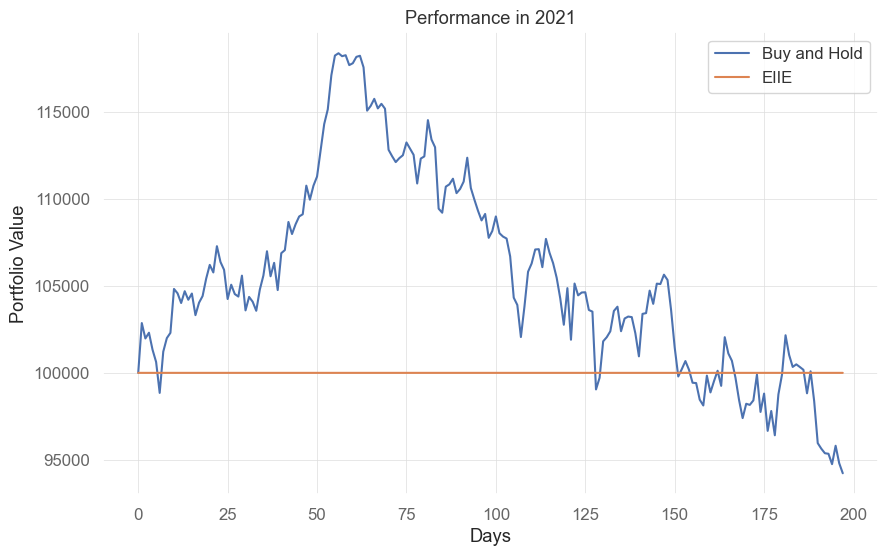

In [18]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()
plt.savefig(f"results/performance_in_2021_episode{episodes}.png")
plt.show()

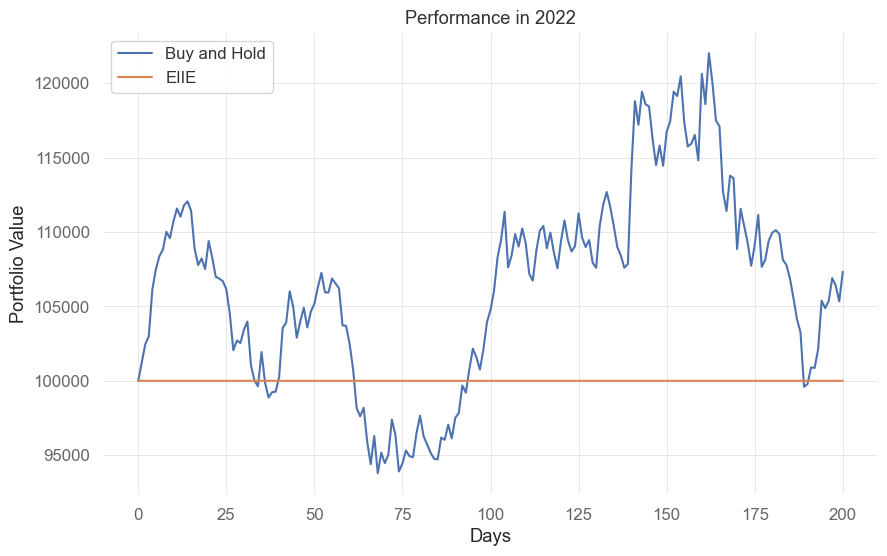

In [19]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()
plt.savefig(f"results/performance_in_2022_episode{episodes}.png")
plt.show()

## Question: 为什么在训练400个episode之后，EIIE的曲线与Buy and Hold的曲线完全重合了呢

应该是因为test model的定义没有重新执行，也可能是对于model的定义没有重新执行，但是重新执行之后仍然完全重合呢，需要重启notebook的内核